In [1]:
import numpy as np
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt

import scipy.sparse as sparse
from scipy.stats import norm
from humanfriendly import format_size

import sklearn
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from adjustText import adjust_text
import shap

import sys, os, time
sys.dont_write_bytecode = True
import conditions, analysis, gen_data

import random
random.seed(1107)
np.random.seed(1107)

import warnings
warnings.filterwarnings('ignore')

PATH = 'Figures'
os.makedirs(PATH, exist_ok = True)

PATH2 = 'CSV_files'
os.makedirs(PATH2, exist_ok = True)

Be sure to set test_cal in conditions.py to True, and be sure to set test_cal back to False when the test calculation is complete.

In [2]:
condition = conditions.calc_condition()
date, Reaction = condition['date'], condition['Reaction']
print(Reaction)
converted = gen_data.data_convert(condition)
catal_cand = gen_data.make_catal_cand(condition, converted)

add_model = condition['add_model']
cand_add_num = condition['cand_add_num']
target_name = condition['target_name']

save_depth = condition['save_depth']
catal_comb, elem_wt = catal_cand['catal_comb'], catal_cand['elem_wt']

add_com = catal_cand['add_com']
add_vect = catal_cand['add_vect']

feat, target = converted['feat'], converted['target']
cur_max = target.max()

print('-' * 80)
model  = ExtraTreesRegressor(n_estimators = 100, random_state = 1107, n_jobs = -1)
cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
analysis.crossvalid(feat, target, model, cvf)
print('-' * 80)

rwgs_250
--------------------------------------------------------------------------------
Train ... RMSE: 0.007, MSE: 0.000, MAE: 0.001, R2: 1.000, RMSE detail (sd: 0.005, min:0.000, max:0.011)
Test ... RMSE: 0.411, MSE: 0.170, MAE: 0.336, R2: 0.801, RMSE detail (sd: 0.035, min:0.312, max:0.488)
--------------------------------------------------------------------------------


In [3]:
def timer(name, alpha=None):
    t0 = time.time()
    yield
    dt = time.time() - t0
    print(f'[{name}] done in {dt:.2f} s')
    if alpha:
        delta = dt.timedelta(seconds=dt * alpha)
        print(f'(estimate {delta} s for processing all)')

def crossvalid(xx, yy, model, cvf):
    mse_trn = []
    mse_tes = []
    mae_trn = []
    mae_tes = []
    r_2_tes = []
    r_2_trn = []
    for train_index, test_index in cvf.split(xx):
        x_trn = np.array(xx)[train_index]
        x_tes = np.array(xx)[test_index]
        y_trn = np.array(yy)[train_index]
        y_tes = np.array(yy)[test_index]
        model.fit(x_trn, y_trn)
        x_trn_pred = model.predict(x_trn)
        x_tes_pred = model.predict(x_tes)

        mse_tes.append(mean_squared_error(x_tes_pred, y_tes))
        mse_trn.append(mean_squared_error(x_trn_pred, y_trn))
        mae_tes.append(mean_absolute_error(x_tes_pred, y_tes))
        mae_trn.append(mean_absolute_error(x_trn_pred, y_trn))
        r_2_tes.append(r2_score(y_tes, x_tes_pred))
        r_2_trn.append(r2_score(y_trn, x_trn_pred))

    rmse_tes = np.sqrt(np.array(mse_tes))
    rmse_trn = np.sqrt(np.array(mse_trn))
    print("Train ... RMSE: %1.3f, MSE: %1.3f, MAE: %1.3f, R2: %1.3f, RMSE detail (sd: %1.3f, min:%1.3f, max:%1.3f)" 
    % (rmse_trn.mean(), np.array(mse_trn).mean(), np.array(mae_trn).mean(), np.array(r_2_trn).mean(), rmse_trn.std(), rmse_trn.min(), rmse_trn.max()))
    print("Test ... RMSE: %1.3f, MSE: %1.3f, MAE: %1.3f, R2: %1.3f, RMSE detail (sd: %1.3f, min:%1.3f, max:%1.3f)" 
    % (rmse_tes.mean(), np.array(mse_tes).mean(), np.array(mae_tes).mean(), np.array(r_2_tes).mean(), rmse_tes.std(), rmse_tes.min(), rmse_tes.max()))
    ret = {}
    ret['trn_rmse'] = rmse_trn.mean()
    ret['trn_mse'] = np.array(mse_trn).mean()
    ret['trn_mae'] = np.array(mae_trn).mean()
    ret['trn_r2'] = np.array(r_2_trn).mean()
    ret['tes_rmse'] = rmse_tes.mean()
    ret['tes_mse'] = np.array(mse_tes).mean()
    ret['tes_mae'] = np.array(mae_tes).mean()
    ret['tes_r2'] = np.array(r_2_tes).mean()
    return ret

def EI(mu, sigma, cur_max):
    Z = (mu - cur_max) / sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma*norm.pdf(Z) # pdf == Probability Density Function
    return ei

def encode(comps, ele):
    if cand_add_num == 2:
        return f"{ele[0]} {comps[0]}, {ele[1]} {comps[1]}"
    elif cand_add_num == 3:
        return f"{ele[0]} {comps[0]}, {ele[1]} {comps[1]}, {ele[2]} {comps[2]}"
    elif cand_add_num == 4:
        return f"{ele[0]} {comps[0]}, {ele[1]} {comps[1]}, {ele[2]} {comps[2]}, {ele[3]} {comps[3]}"
    elif cand_add_num == 5:
        return f"{ele[0]} {comps[0]}, {ele[1]} {comps[1]}, {ele[2]} {comps[2]}, {ele[3]} {comps[3]}, {ele[4]} {comps[4]}"

def get_encode(idx, comps):
    return [encode(comps, ele) for ele in catal_comb[idx]]

def pred_std_csr(X, trees, predictions, min_variance=0.0):
    std = np.zeros(X.shape[0])
    for tree in trees:
        var_tree = tree.tree_.impurity[tree.apply(X)]
        var_tree[var_tree < min_variance] = min_variance
        mean_tree = tree.predict(X)
        std += var_tree + mean_tree ** 2
    std /= len(trees)
    std -= predictions ** 2.0
    std[std < 0.0] = 0.0
    std = std ** 0.5
    return std

def calc_ei(elem_wt):
    if add_model == 0 and cand_add_num != 0:
        elem_pattern = sum([d * w for d, w in zip(add_vect, elem_wt)])
    elif add_model == 1 and cand_add_num != 0:
        elem_com_pattern = sum([d * w for d, w in zip(add_com, elem_wt)])
        elem_vect_pattern = sum([d * w for d, w in zip(add_vect, elem_wt)])
        elem_pattern = sparse.hstack([elem_com_pattern, elem_vect_pattern])
        del add_vect_pattern
    elif add_model == 2 and cand_add_num != 0:
        elem_pattern = sum([d * w for d, w in zip(add_com, elem_wt)])
    else:
        print('Additive passed...')
    print(f'elem_pattern_A{add_model}:', elem_pattern.shape, format_size(elem_pattern.data.nbytes))
    mu = model.predict(elem_pattern)
    sigma = pred_std_csr(elem_pattern, model.estimators_, mu)
    idx_s = sigma == 0
    sigma[idx_s] = 1e-5
    scores = EI(mu, sigma, cur_max)
    if save_depth == -1:
        idx = scores.argsort()[::-1]
    else:
        idx = scores.argsort()[::-1][:save_depth]
    return pd.DataFrame({'ei': scores[idx]}, index=get_encode(idx, elem_wt))


elem_pattern_A2: (2869685, 7) 160.7 MB
(100, 1)


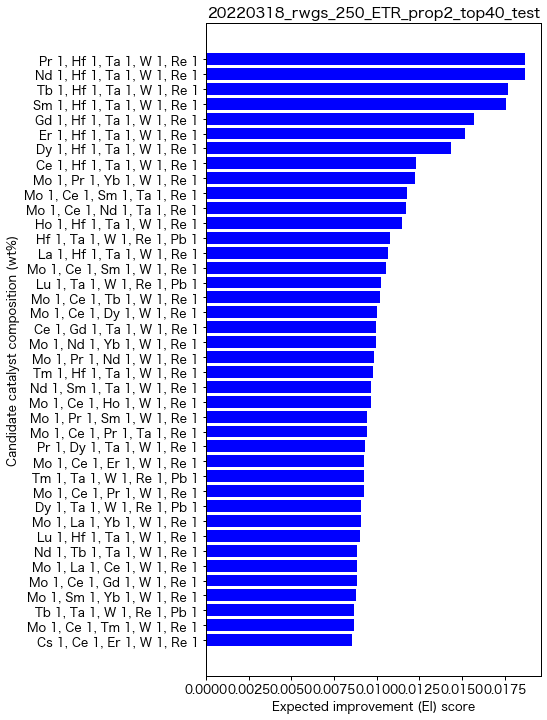

In [4]:
model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=-1)
model.fit(feat, target)

cand = pd.DataFrame()
for i in range(len(elem_wt)):
    c = calc_ei(elem_wt[i])
    cand = pd.concat([c, cand])

os.makedirs('out', exist_ok=True)
print(cand.shape)
cand.to_csv(f'out/{date}_{Reaction}_cand_ETR_prop{add_model}_test.csv')

plt.figure(facecolor='white', figsize = (6,12))
third_el = cand.sort_values("ei")
third_el = third_el.iloc[-40:, :]
x = np.arange(len(third_el))
plt.barh(x,third_el.loc[:,"ei"], color = 'blue')
plt.yticks(x, third_el.index)
plt.title(f'{date}_{Reaction}_ETR_prop{add_model}_top40_test')
plt.xlabel('Expected improvement (EI) score')
plt.ylabel('Candidate catalyst composition (wt%)')
plt.savefig(f"out/{date}_{Reaction}_ETR_prop{add_model}_top40_test.png", dpi = 600, bbox_inches = "tight")